# Simulation 
#### The `hits` module contains simulation functions for the incidence of micrometeoroid hits on Gaia. The functions are detailed here.

The simulation functions are packaged within `hits.hitsimulator`. There are several functions, many of which are probability distribution samplers. These functions are chained together to generate a complete simulation of the Gaia datasets, complete with noise.
The simulation is largely based on Lennart Lindegren's [SAG-LL-031 technical note](http://www.astro.lu.se/~lennart/Astrometry/TN/Gaia-LL-031-20000713-Effects-of-micrometeoroids-on-GAIA-attitude.pdf).
___

In order to customise parameters on the simulation, a file - `conf.py` - can be written containing parameters on variables. This is outlined in the dummy conf.py file included with the package. This notebook is written without a `conf.py` file, therefore upon import a message is given to indicate this.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import hits
import hits.hitsimulator as hs
import hits.hitdetector as hd

conf.py not found. Using default values.


The first part of the simulation in `hits.hitsimulator` is the simulation of the incidence of micrometeoroid hits on the disk of the satellite. This is handled by `hs.hit_distribution`. An explanation is shown here:

In [3]:
help(hs.hit_distribution)

Help on CPUDispatcher in module hits.hitsimulator:

hit_distribution(hits)
    Accepts:
    
        the number of hits to simulate on the satellite.
    
    A sampler for hits distributed uniformly across a disk.
    
    Returns:
    
        a tuple of the angle and the radius of the hits' locations.



The hits are simulated as being uniformly distributed across the disk of the satellite.

Text(0.5,1.05,'Points generated uniformly \n across a disk \n')

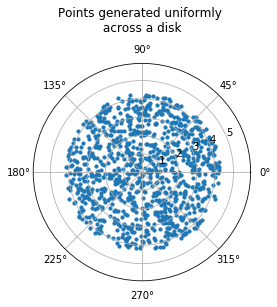

In [4]:
theta, r = zip(*hs.hit_distribution(1000))  # Unpack then zip to isolate coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.scatter(theta, r, s=10)
ax.set_title("Points generated uniformly \n across a disk \n")

The points here are observably uniformly distributed across the disk. The hit locations determine the torque applied for a given mass of particle. The particle flux is determined as detailed in Lindegren's technical note.

This is a relation versus mass as described by Yamakoshi (Extraterrestrial dust, ASSL 181, 1994). A plot of this relation for masses between 1e-13 and 1e-7 kg is shown below. Note the x axis is logarithmic. `hs.masses` is an array of masses appropriate to the simulation of Gaia data.

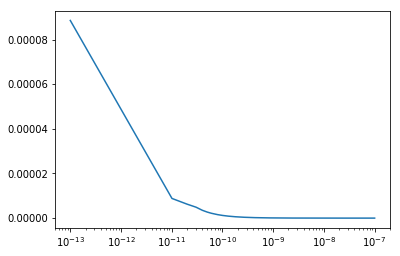

In [5]:
flux = [hs.flux(x) for x in hs.masses]
plt.semilogx(hs.masses, flux)

The calculation for the frequency of impacts of each mass is also detailed in Lindegren's technical note. Since the fluxes are given as the flux of masses above a mass, m, the impact frequency is implemented here by binning the fluxes of masses between each mass in the mass distribution given. This therefore means the frequency distribution produced is shorter by 1 than the mass distribution from which it is made. For sufficiently large mass distributions, such as `hs.masses`, this has negligible effect. The distribution is as follows.

Text(0,0.5,'Impact frequency/Hz')

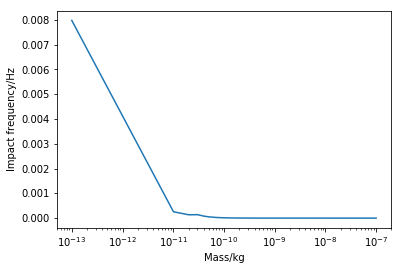

In [6]:
plt.semilogx(hs.masses[:-1], hs.freq(hs.masses))
plt.xlabel("Mass/kg")
plt.ylabel("Impact frequency/Hz")

Using these data, `hs.p_distribution` is a probability distribution sampler from the poisson distribution of hit impacts. Given an array of frequencies, such as those generated from `hs.masses`, the sampler generates an array of hits occuring in a second corresponding to the frequencies, and another array of the total hits. Since the total frequency is roughly 1 impact every hundred seconds, the expected output is normally no hits.

In [7]:
hs.p_distribution(hs.freq(hs.masses))[1]  # This will normally return an empty list

[]

Further probability samplers included within the simulation include:
* A normal distribution sampler to determine the AOCS response time for the hit
* A normal distribution sampler to determine the number of turning points in the AOCS response

The values used for these probability distributions are drawn from `conf.py` and are therefore customisable. Since they are empirically calculated, they are not distributed with the simulation. Rather, indicative values are used to enable the simulation of data. The actual AOCS characteristics are, therefore, not necessarily completely realistic.
___
The AOCS response is handled by a custom object. This object takes the amplitude of an impact as an input and by sampling from the relevant distributions is able to create a realistic decay pattern. An example of this is shown below.

In [8]:
# Initialise an instance of the AOCSResponse class
response = hs.AOCSResponse()

In [9]:
# A new instance will have no data within it
response._data

[]

In [10]:
# By applying an amplitude, the class calculates a decay pattern for a hit of that magnitude
response(12)

In [11]:
response._data

[12.0,
 11.49177368483423,
 10.704376062173544,
 9.675100902709698,
 8.445579253188203,
 7.060410649255415,
 5.565793807379535,
 4.00819359422151,
 2.4330779688356032,
 0.8837547648221804,
 -0.599666229210045,
 -1.9811652698211142,
 -3.229543229670234,
 -4.318980461250599,
 -5.229418880715473,
 -5.946767239392163,
 -6.4629343001649735,
 -6.775698984052021,
 -6.888430405473462,
 -6.809673998081522,
 -6.552622591395812,
 -6.134493296637088,
 -5.575832382620828,
 -4.899770972938083,
 -4.131254395334811,
 -3.2962674008541204,
 -2.421076295863853,
 -1.5315073585509809,
 -0.6522788164668148,
 0.19359877599483674,
 0.9853416164274299,
 1.7048219110741991,
 2.33690097950985,
 2.869662825568267,
 3.2945476610373254,
 3.6063875847856868,
 3.8033491198483125,
 3.88678953996537,
 3.8610358309622574,
 3.733096698014654,
 3.5123192253667352,
 3.210002609774741,
 2.838981822987208,
 2.413194122314953,
 1.9472410414997667,
 1.4559578846450194,
 0.9540018489522988,
 0.45546875813887855,
 -0.02645295731

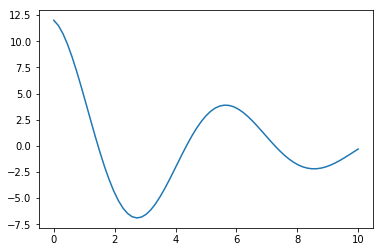

In [12]:
# An expected response pattern to a hit of magnitude 12 mas/s is shown here
plt.plot(np.linspace(0,10,len(response._data)), response._data)

By combining these, the simulation can produce a simulation of hit incidence and AOCS response as shown in the AGIS alongscan data for Gaia.
___
The simulation is generated by two functions, `hs.generate_event` and `hs.generate_data`. `hs.generate_data` calls `hs.generate_event` repeatedly over a time series to generate a series of hit events and their respective responses. Noise is then added to the signal to simulate a realistic dataset.

An example of a basic dataset is shown below.

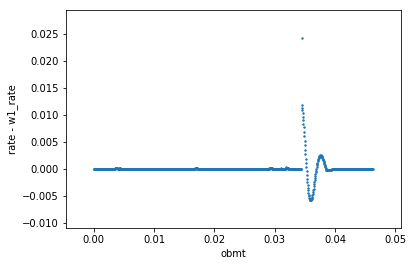

In [13]:
df = hs.generate_data(1000, noise=None)
hd.plot_anomaly(df)

The data is simplistic but realistic. Noise can be added to the simulation through the kwarg `noise`. Acceptable noise types as of version 0.1.0 are `gaussian` and `periodic`. They can be passed as any iterable.

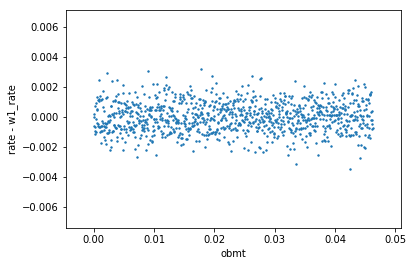

In [14]:
df = hs.generate_data(1000, noise='gaussian')
hd.plot_anomaly(df)

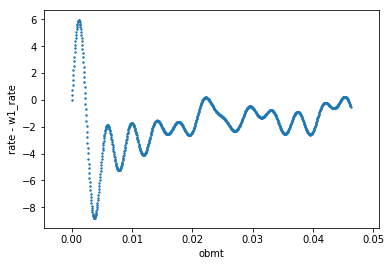

In [15]:
df = hs.generate_data(1000, noise='periodic')
hd.plot_anomaly(df)

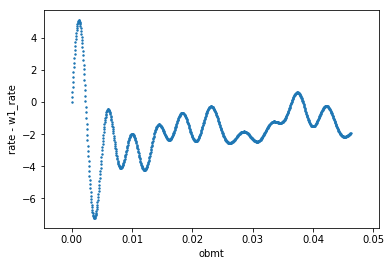

In [16]:
df = hs.generate_data(1000, noise='gaussian and periodic')
hd.plot_anomaly(df)